# Linear stability analysis of 2-layer QG model

In [1]:
import platform
import numpy as np
import sympy
from sympy import symbols, solve
import scipy
from scipy.signal import savgol_filter
import matplotlib
import matplotlib.pyplot as plt
import cmocean as cmo
import seaborn as sns
sns.set_style('darkgrid')

g = 9.81 # gravitational acceleration in m/s^2

In [2]:
# Version check
print("Python "+platform.python_version())
print("numpy "+np.__version__)
print("sympy "+sympy.__version__)
print("scipy "+scipy.__version__)
print("matplotlib "+matplotlib.__version__)
print("cmocean "+cmo.__version__)
print("seaborn "+sns.__version__)

Python 3.11.10
numpy 2.1.2
sympy 1.13.3
scipy 1.14.1
matplotlib 3.9.2
cmocean v3.0.3
seaborn 0.13.2


## Computing the maximum growth rates

In [3]:
def c_im_max(kappa,theta,alpha_x,alpha_y,mu,f0,beta,U,V,rho1,rho2,H1,H2):
    """
    Computes the growth rate of the most unstable mode for the 2-layer QG model

    kappa, theta: wavenumber magnitude and angle
    alpha_x, alpha_y: x and y components of bottom slope
    mu: inverse frictional timescale
    f0: Coriolis parameter
    beta: meridional gradient of Coriolis parameter
    U, V: background velocity shear
    rho1, rho2: density of the two layers
    H1, H2: depth of the two layers
    """
    # Calculating relevant parameters
    gp = g*(rho2-rho1)/rho2
    F1 = f0**2/(gp*H1)
    F2 = f0**2/(gp*H2)

    # Coordinate transformation: unit vectors in tangential (e1) and normal (e2) direction of wavenumber vector
    U_new = U*np.cos(theta) + V*np.sin(theta) # project U on e1
    beta_new = beta*np.cos(theta) # project beta on e2
    S = f0/H2 * (alpha_y*np.cos(theta) - alpha_x*np.sin(theta)) # project topography on e2
    
    # Solving the equation
    kappa2 = kappa**2
    a1 = kappa2 * (kappa2 + F1 + F2)
    a2 = - U_new*kappa2 * (kappa2 + 2*F2) + beta_new * (2*kappa2 + F1 + F2) + (kappa2 + F1) * (S + 1j*mu*kappa)
    a3 = (-U_new*kappa2 + beta_new) * (-F2*U_new + beta_new + S + 1j*mu*kappa)
    D = a2**2 - 4*a1*a3

    sol1 = (-a2 + np.sqrt(D))/(2*a1)
    sol2 = (-a2 - np.sqrt(D))/(2*a1)

    # Computing the imaginary parts of the solutions
    cim1 = np.imag(sol1)
    cim2 = np.imag(sol2)

    # If growth rates are negative, make them NaN (no growth)
    cim1 = cim1 if cim1 > 0 else np.nan
    cim2 = cim2 if cim2 > 0 else np.nan

    return np.nanmax((kappa*cim1, kappa*cim2)) # return max growth rate

## Zonal case

We consider the case where the background flow and the isobaths are zonal.

In [3]:
def growth_rate_curve_zonal(ax, label, color, linestyle, k_range, alpha, mu, f0, beta, U, rho1, rho2, H1, H2):
    c_plot = np.array([c_im_max(k, 0, 0, alpha, mu, f0, beta, U, 0, rho1, rho2, H1, H2) for k in k_range])
    gp = g*(rho2-rho1)/rho2
    F1 = f0**2/(gp*H1)
    F2 = f0**2/(gp*H2)
    F = F1 + F2
    ax.plot(k_range/np.sqrt(F), c_plot*86400, label=label, color=color, linestyle=linestyle)


def plotContourGrowthRateZonal(fig, ax, k, s, mu, f0, beta, U, rho1, rho2, H1, H2, levels):
    gp = g*(rho2-rho1)/rho2
    F1 = f0**2/(gp*H1)
    F2 = f0**2/(gp*H2)
    F = F1 + F2
    
    growth_rate = np.zeros((len(s),len(k)))
    max_k = np.zeros(len(s))
    for i in range(np.shape(growth_rate)[0]):
        for j in range(np.shape(growth_rate)[1]):
            growth_rate[i,j] = c_im_max(k[j], 0, 0, s[i], mu, f0, beta, U, 0, rho1, rho2, H1, H2) # assuming l=0
        if np.isnan(growth_rate[i,:]).all():
            max_k[i] = np.nan
        else:
            max_k[i] = k[np.nanargmax(growth_rate[i,:])]
    cax = ax.contourf(k/np.sqrt(F),s*1e3,growth_rate*86400*1e3,cmap='cmo.amp',levels=levels,extend='max')
    cbar = fig.colorbar(cax,ax=ax,extend='both')
    cbar.set_label(r'Growth rate $\kappa c_i$ ($10^{-3}$ day$^{-1}$)',fontsize=12)
    max_k_smooth = savgol_filter(max_k,window_length=8,polyorder=2)
    ax.plot(max_k_smooth/np.sqrt(F),s*1e3,'k')
    ax.plot(k/np.sqrt(F),np.zeros(len(k)),'k',alpha=0.3)
    ax.set_xlim(0,2)
    ax.set_xlabel(r'$\kappa/\kappa_d$',fontsize=12)
    ax.set_ylabel(r'Bottom slope ($10^{-3}$)',fontsize=12)
    ax.tick_params(axis='both',labelsize=11)


def mostUnstableZonal(k_plot, alpha, mu, f0, beta, U, rho1, rho2, H1, H2):
    c_plot = np.array([c_im_max(k,0,0,alpha,mu,f0,beta,U,0,rho1,rho2,H1,H2) for k in k_plot])
    if np.isnan(c_plot).all():
        return np.nan, np.nan
    ind = np.nanargmax(c_plot)
    k_injection = k_plot[ind]
    c_injection = c_plot[ind]

    gp = g*(rho2-rho1)/rho2
    F1 = f0**2/(gp*H1)
    F2 = f0**2/(gp*H2)
    F = F1 + F2

    return k_injection/np.sqrt(F), c_injection*86400

In [4]:
# Define parameters
H1 = 1000
H2 = 4000
rho1 = 1027.5
rho2 = 1028
f0 = 1e-4
beta = 1e-11
U = 0.04

gp = g*(rho2-rho1)/rho2
F1 = f0**2/(gp*H1)
F2 = f0**2/(gp*H2)
F = F1 + F2
print("Deformation radius: %.f km"%(1e-3/np.sqrt(F)))

mu_weak = 1/(86400*100)
mu_intm = 1/(86400*10)
mu_strong = 1/(86400*1)

Deformation radius: 20 km


/tmp/ipykernel_83511/369599679.py:42: RuntimeWarning: All-NaN axis encountered
  return np.nanmax((kappa*cim1, kappa*cim2)) # return max growth rate


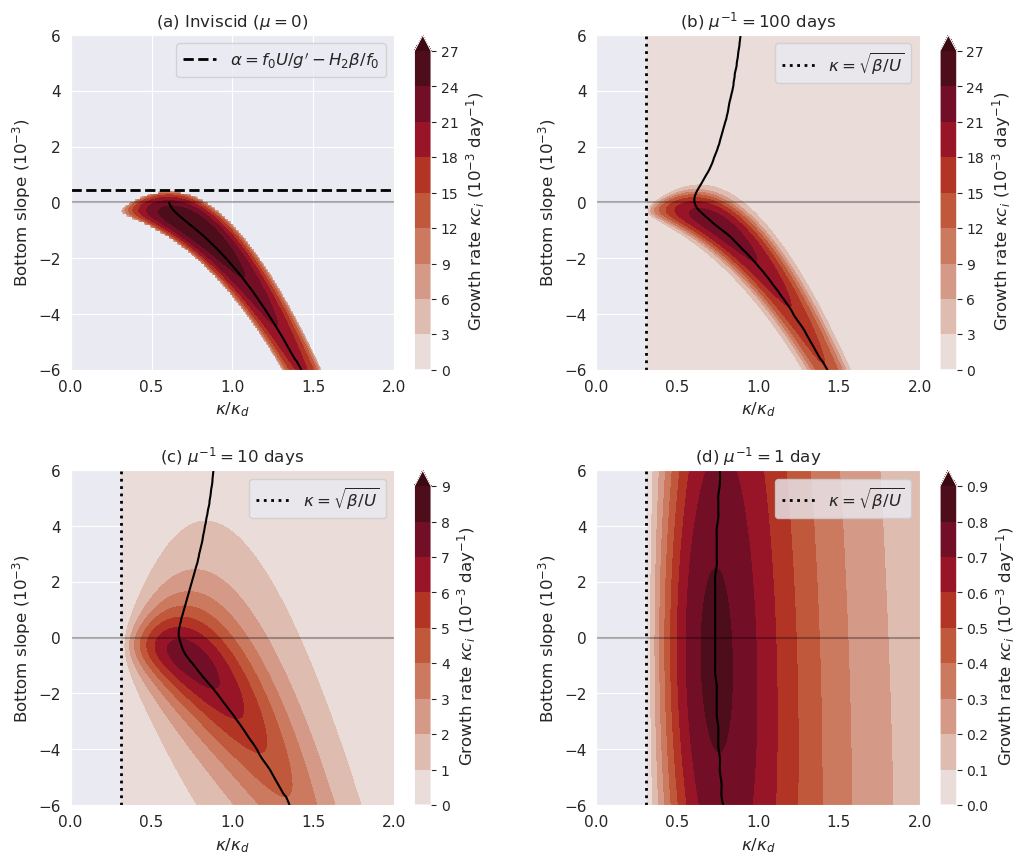

In [ ]:
k_range = np.arange(1e-7,2e-4,5e-7)
k_range_fine = np.arange(1e-7,2e-4,1e-7)
s_range = np.arange(-6e-3,6.1e-3,1e-4)

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(12,10))
plotContourGrowthRateZonal(fig, ax1, k_range_fine, s_range, 0, f0, beta, U, rho1, rho2, H1, H2, np.arange(0,30,3))
plotContourGrowthRateZonal(fig, ax2, k_range, s_range, mu_weak, f0, beta, U, rho1, rho2, H1, H2, np.arange(0,30,3))
plotContourGrowthRateZonal(fig, ax3, k_range, s_range, mu_intm, f0, beta, U, rho1, rho2, H1, H2, np.arange(0,10,1))
plotContourGrowthRateZonal(fig, ax4, k_range, s_range, mu_strong, f0, beta, U, rho1, rho2, H1, H2, np.arange(0,1,0.1))

ax1.set_title(r'(a) Inviscid ($\mu = 0$)')
ax2.set_title(r'(b) $\mu^{-1} = 100$ days')
ax3.set_title(r'(c) $\mu^{-1} = 10$ days')
ax4.set_title(r'(d) $\mu^{-1} = 1$ day')

ax1.plot(k_range_fine/np.sqrt(F),np.ones(len(k_range_fine))*(f0*U/gp-H2*beta/f0)*1e3,'k',linewidth=2,linestyle='dashed',label=r'$\alpha = f_0 U/g^\prime - H_2\beta/f_0$')
ax1.legend(fontsize=12)

for ax in [ax2,ax3,ax4]:
    ax.vlines(np.sqrt(beta/U)/np.sqrt(F),-6,6,color='k',linewidth=2,linestyle='dotted',label=r'$\kappa = \sqrt{\beta/U}$')
    ax.legend(fontsize=12)

plt.subplots_adjust(hspace=0.3,wspace=0.3)
plt.show()

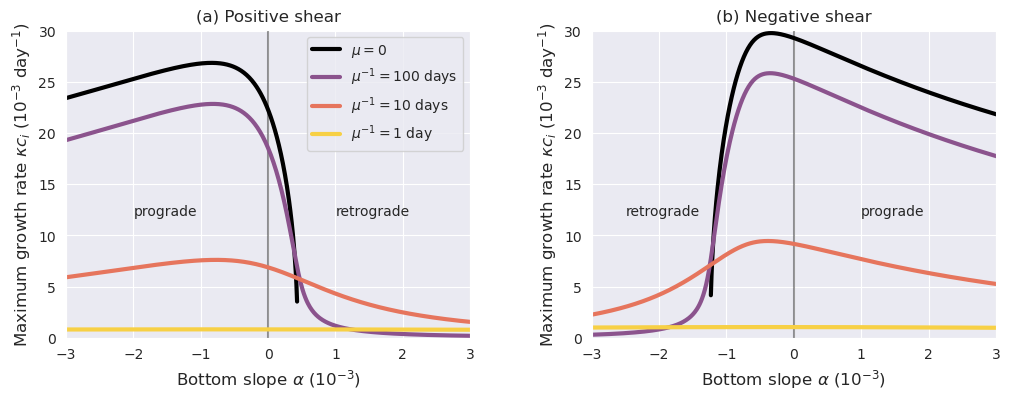

In [ ]:
k_range = np.arange(1e-7,2e-4,2e-8)
s_plot = np.arange(-3e-3,3.1e-3,1e-5)

c_injection_strong_Upos = np.zeros(len(s_plot))
c_injection_intm_Upos = np.zeros(len(s_plot))
c_injection_weak_Upos = np.zeros(len(s_plot))
c_injection_nofric_Upos = np.zeros(len(s_plot))
c_injection_strong_Uneg = np.zeros(len(s_plot))
c_injection_intm_Uneg = np.zeros(len(s_plot))
c_injection_weak_Uneg = np.zeros(len(s_plot))
c_injection_nofric_Uneg = np.zeros(len(s_plot))

for i,s in enumerate(s_plot):
    _,c_injection_strong_Upos[i] = mostUnstableZonal(k_range, s, mu_strong, f0, beta, U, rho1, rho2, H1, H2)
    _,c_injection_intm_Upos[i] = mostUnstableZonal(k_range, s, mu_intm, f0, beta, U, rho1, rho2, H1, H2)
    _,c_injection_weak_Upos[i] = mostUnstableZonal(k_range, s, mu_weak, f0, beta, U, rho1, rho2, H1, H2)
    _,c_injection_nofric_Upos[i] = mostUnstableZonal(k_range, s, 0, f0, beta, U, rho1, rho2, H1, H2)

    _,c_injection_strong_Uneg[i] = mostUnstableZonal(k_range, s, mu_strong, f0, beta, U*-1, rho1, rho2, H1, H2)
    _,c_injection_intm_Uneg[i] = mostUnstableZonal(k_range, s, mu_intm, f0, beta, U*-1, rho1, rho2, H1, H2)
    _,c_injection_weak_Uneg[i] = mostUnstableZonal(k_range, s, mu_weak, f0, beta, U*-1, rho1, rho2, H1, H2)
    _,c_injection_nofric_Uneg[i] = mostUnstableZonal(k_range, s, 0, f0, beta, U*-1, rho1, rho2, H1, H2)


cmap = matplotlib.colormaps.get_cmap('cmo.thermal') # for old version on laptop: cm, new: colormaps
colors = [cmap(i) for i in np.linspace(0.4,0.9,3)]

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.plot(s_plot*1e3,c_injection_nofric_Upos*1e3,color='k',label=r'$\mu=0$',linewidth=3)
ax1.plot(s_plot*1e3,c_injection_weak_Upos*1e3,color=colors[0],label=r'$\mu^{-1} = 100$ days',linewidth=3)
ax1.plot(s_plot*1e3,c_injection_intm_Upos*1e3,color=colors[1],label=r'$\mu^{-1} = 10$ days',linewidth=3)
ax1.plot(s_plot*1e3,c_injection_strong_Upos*1e3,color=colors[2],label=r'$\mu^{-1} = 1$ day',linewidth=3)

ax2.plot(s_plot*1e3,c_injection_nofric_Uneg*1e3,'k',label=r'$\mu=0$',linewidth=3)
ax2.plot(s_plot*1e3,c_injection_weak_Uneg*1e3,color=colors[0],label=r'$\mu^{-1} = 100$ days',linewidth=3)
ax2.plot(s_plot*1e3,c_injection_intm_Uneg*1e3,color=colors[1],label=r'$\mu^{-1} = 10$ days',linewidth=3)
ax2.plot(s_plot*1e3,c_injection_strong_Uneg*1e3,color=colors[2],label=r'$\mu^{-1} = 1$ day',linewidth=3)

for ax in [ax1,ax2]:
    ax.set_xlim(-3,3)
    ax.set_ylim(0,30.1)
    ax.set_xlabel(r'Bottom slope $\alpha \ (10^{-3})$',fontsize=12)
    ax.set_ylabel(r'Maximum growth rate $\kappa c_i$ ($10^{-3}$ day$^{-1}$)',fontsize=12)
    ax.vlines(0,0,30,color='k',alpha=0.4,zorder=1)
ax1.legend(fontsize=10)
ax1.set_title(r'(a) Positive shear',fontsize=12)
ax2.set_title(r'(b) Negative shear',fontsize=12)
ax1.text(-2,12,'prograde')
ax1.text(1,12,'retrograde')
ax2.text(-2.5,12,'retrograde')
ax2.text(1,12,'prograde')
plt.subplots_adjust(wspace=0.3)
plt.show()

## Nonzonal case: variation of orientation mean shear and topography

### Load data

See `theory_nonzonal.py` for calculation and `theory.sh` for input parameters used to produce these data files

In [2]:
path2data = '../../Data/calculations/theory/' # change this to the path to the data

In [ ]:
U_45deg_nofric_fine_k = np.load(path2data+'topo_nonzonal_U_45deg_nofric_fine_k.npy')
U_45deg_nofric_fine_sigma = np.load(path2data+'topo_nonzonal_U_45deg_nofric_fine_sigma.npy')
U_45deg_nofric_fine_theta_cr = np.load(path2data+'topo_nonzonal_U_45deg_nofric_fine_theta_cr.npy')
U_45deg_nofric_fine_cr = np.load(path2data+'topo_nonzonal_U_45deg_nofric_fine_cr.npy')

U_45deg_mu_weak_fine_k = np.load(path2data+'topo_nonzonal_U_45deg_mu_weak_fine_k.npy')
U_45deg_mu_weak_fine_sigma = np.load(path2data+'topo_nonzonal_U_45deg_mu_weak_fine_sigma.npy')
U_45deg_mu_weak_fine_theta_cr = np.load(path2data+'topo_nonzonal_U_45deg_mu_weak_fine_theta_cr.npy')
U_45deg_mu_weak_fine_cr = np.load(path2data+'topo_nonzonal_U_45deg_mu_weak_fine_cr.npy')

U_45deg_mu_intm_fine_k = np.load(path2data+'topo_nonzonal_U_45deg_mu_intm_fine_k.npy')
U_45deg_mu_intm_fine_sigma = np.load(path2data+'topo_nonzonal_U_45deg_mu_intm_fine_sigma.npy')
U_45deg_mu_intm_fine_theta_cr = np.load(path2data+'topo_nonzonal_U_45deg_mu_intm_fine_theta_cr.npy')
U_45deg_mu_intm_fine_cr = np.load(path2data+'topo_nonzonal_U_45deg_mu_intm_fine_cr.npy')

In [ ]:
U_300deg_nofric_fine_k = np.load(path2data+'topo_nonzonal_U_300deg_nofric_fine_k.npy')
U_300deg_nofric_fine_sigma = np.load(path2data+'topo_nonzonal_U_300deg_nofric_fine_sigma.npy')
U_300deg_nofric_fine_theta_cr = np.load(path2data+'topo_nonzonal_U_300deg_nofric_fine_theta_cr.npy')
U_300deg_nofric_fine_cr = np.load(path2data+'topo_nonzonal_U_300deg_nofric_fine_cr.npy')

U_300deg_mu_weak_fine_k = np.load(path2data+'topo_nonzonal_U_300deg_mu_weak_fine_k.npy')
U_300deg_mu_weak_fine_sigma = np.load(path2data+'topo_nonzonal_U_300deg_mu_weak_fine_sigma.npy')
U_300deg_mu_weak_fine_theta_cr = np.load(path2data+'topo_nonzonal_U_300deg_mu_weak_fine_theta_cr.npy')
U_300deg_mu_weak_fine_cr = np.load(path2data+'topo_nonzonal_U_300deg_mu_weak_fine_cr.npy')

U_300deg_mu_intm_fine_k = np.load(path2data+'topo_nonzonal_U_300deg_mu_intm_fine_k.npy')
U_300deg_mu_intm_fine_sigma = np.load(path2data+'topo_nonzonal_U_300deg_mu_intm_fine_sigma.npy')
U_300deg_mu_intm_fine_theta_cr = np.load(path2data+'topo_nonzonal_U_300deg_mu_intm_fine_theta_cr.npy')
U_300deg_mu_intm_fine_cr = np.load(path2data+'topo_nonzonal_U_300deg_mu_intm_fine_cr.npy')

In [3]:
# For each alpha, compute the angle of the slope for which the lower layer PV gradient is perpendicular to the mean shear

alpha_range = np.arange(0,3.1e-3,5e-5)
phi_range_coarse = np.deg2rad(np.arange(0,361,5))
phi_range_fine = np.deg2rad(np.arange(0,361,1))

H1 = 1000
H2 = 4000
rho1 = 1027.5
rho2 = 1028
f0 = 1e-4
beta = 1e-11

gp = g*(rho2-rho1)/rho2
F1 = f0**2/(gp*H1)
F2 = f0**2/(gp*H2)
F = F1 + F2


def compPerpMax(alpha,U_angle):
    U = 0.04*np.cos(U_angle*np.pi/180)
    V = 0.04*np.sin(U_angle*np.pi/180)
    phi = sympy.Symbol('phi', real=True)
    result = solve(f0/(1*H2)*alpha*sympy.cos(phi)*U + f0/(1*H2)*alpha*sympy.sin(phi)*V + beta*V,phi)
    if not result:
        return np.nan
    elif len(result) == 1:
        angle_topo = float(result[0])
        if angle_topo < 0:
            return np.nan
        else:
            return angle_topo
    elif len(result) == 2:
        angle_topo_0 = float(result[0])
        angle_topo_1 = float(result[1])
        angle_max = np.max([angle_topo_0,angle_topo_1])
        if angle_max < 0:
            return np.nan
        else:
            return angle_max
    
        
def compPerpMin(alpha,U_angle):
    U = 0.04*np.cos(U_angle*np.pi/180)
    V = 0.04*np.sin(U_angle*np.pi/180)
    phi = sympy.Symbol('phi', real=True)
    result = solve(f0/H2*alpha*sympy.cos(phi)*U + f0/H2*alpha*sympy.sin(phi)*V + beta*V,phi)
    if not result:
        return np.nan
    elif len(result) == 1:
        angle_topo = float(result[0])
        if angle_topo > 0:
            return np.nan
        else:
            return angle_topo
    elif len(result) == 2:
        angle_topo_0 = float(result[0])
        angle_topo_1 = float(result[1])
        angle_min = np.min([angle_topo_0,angle_topo_1])
        if angle_min > 0:
            return np.nan
        else:
            return angle_min

alpha_range = np.arange(0,3.1e-3,5e-5)
angle_range_45 = np.array([compPerpMax(alpha,45) for alpha in alpha_range])
angle_range_300 = np.array([compPerpMax(alpha,300) for alpha in alpha_range])

### Figures

In [6]:
sns.set_style('whitegrid')

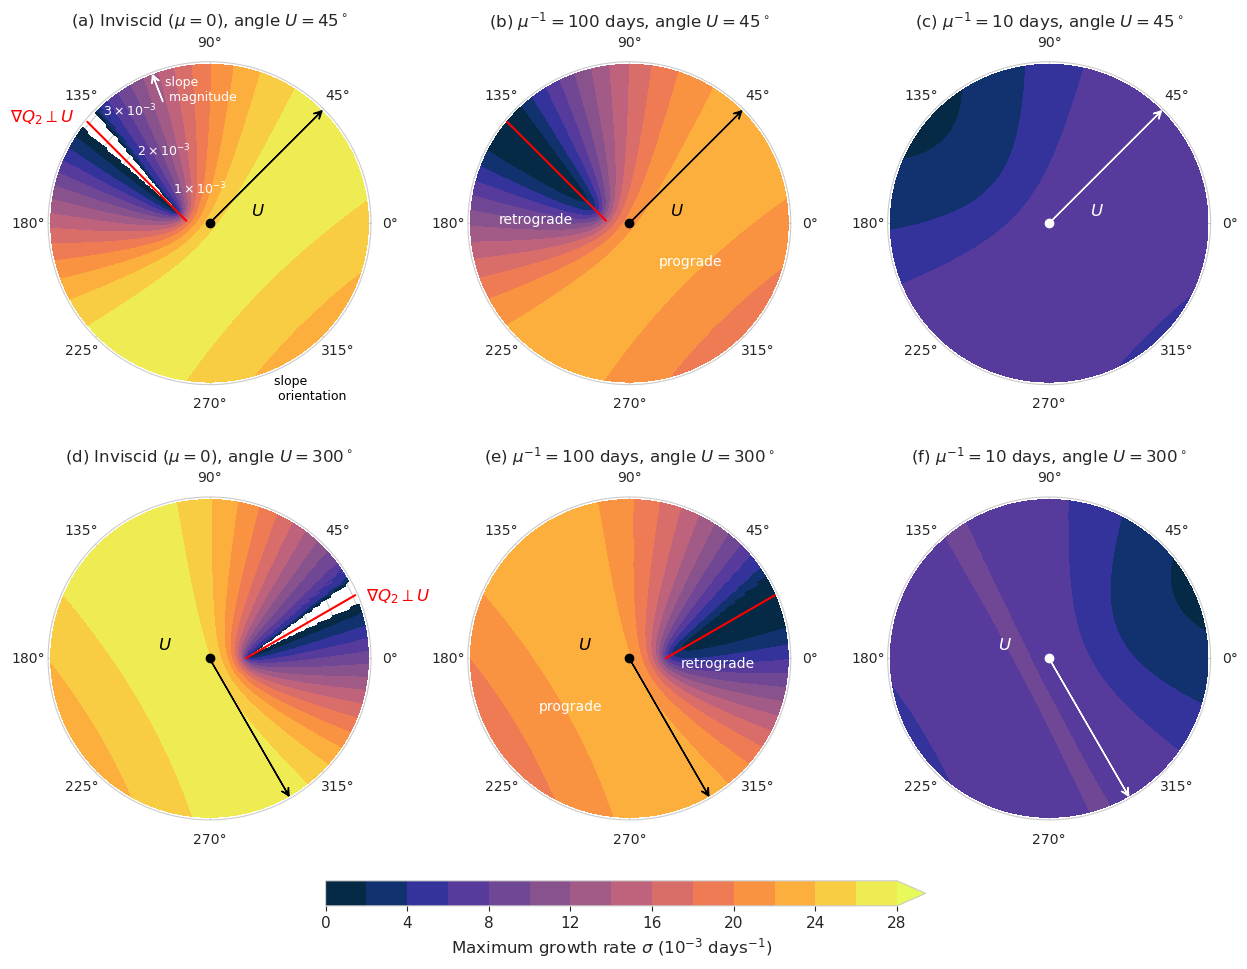

In [7]:
def plotNonzonalSigma(fig,ax,data,shear_angle,phi_range,levels=25,arrowcol='k'):
    plot = ax.contourf(phi_range,alpha_range,data,cmap='cmo.thermal',extend='max',levels=levels)
    ax.set_yticklabels([])
    ax.arrow(np.deg2rad(shear_angle),0,0,3e-3,edgecolor=arrowcol,length_includes_head=True,head_length=1e-4,head_width=np.pi/60,overhang=1.5)
    ax.set_ylim(0,3.1e-3)
    ax.scatter(0,0,color=arrowcol)
    return plot

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(15,10),subplot_kw={'projection': 'polar'})

levels = np.arange(0,28.1,2)
plot1=plotNonzonalSigma(fig,ax1,U_45deg_nofric_fine_sigma*1e3,45,phi_range_fine,levels=levels)
plotNonzonalSigma(fig,ax2,U_45deg_mu_weak_fine_sigma*1e3,45,phi_range_fine,levels=levels)
plotNonzonalSigma(fig,ax3,U_45deg_mu_intm_fine_sigma*1e3,45,phi_range_fine,levels=levels,arrowcol='white')
plotNonzonalSigma(fig,ax4,U_300deg_nofric_fine_sigma*1e3,300,phi_range_fine,levels=levels)
plotNonzonalSigma(fig,ax5,U_300deg_mu_weak_fine_sigma*1e3,300,phi_range_fine,levels=levels)
plotNonzonalSigma(fig,ax6,U_300deg_mu_intm_fine_sigma*1e3,300,phi_range_fine,levels=levels,arrowcol='white')#(0,8.1,0.5)

cbar_ax = fig.add_axes([0.31, 0.03, 0.4, 0.025])
cbar = fig.colorbar(plot1, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=11)
cbar.set_label(r'Maximum growth rate $\sigma$ ($10^{-3}$ days$^{-1}$)',fontsize=12)

ax1.set_title(r'(a) Inviscid ($\mu = 0$), angle $U = 45^\circ$')
ax2.set_title(r'(b) $\mu^{-1} = 100$ days, angle $U = 45^\circ$')
ax3.set_title(r'(c) $\mu^{-1} = 10$ days, angle $U = 45^\circ$')
ax4.set_title(r'(d) Inviscid ($\mu = 0$), angle $U = 300^\circ$')
ax5.set_title(r'(e) $\mu^{-1} = 100$ days, angle $U = 300^\circ$')
ax6.set_title(r'(f) $\mu^{-1} = 10$ days, angle $U = 300^\circ$')

for ax in [ax1,ax2]:
    ax.text(np.deg2rad(10),0.8e-3,'$U$',fontsize=12,color='k')
for ax in [ax4,ax5]:
    ax.text(np.deg2rad(170),1e-3,'$U$',fontsize=12,color='k')

ax3.text(np.deg2rad(10),0.8e-3,'$U$',fontsize=12,color='white')
ax6.text(np.deg2rad(170),1e-3,'$U$',fontsize=12,color='white')

ax1.plot(angle_range_45,alpha_range,color='r')
ax2.plot(angle_range_45,alpha_range,color='r')
ax4.plot(angle_range_300,alpha_range,color='r')
ax5.plot(angle_range_300,alpha_range,color='r')
ax1.text(np.deg2rad(153),4.3e-3,r'$\nabla Q_2 \perp U$',fontsize=12,color='r')
ax4.text(np.deg2rad(20),3.2e-3,r'$\nabla Q_2 \perp U$',fontsize=12,color='r')

ax1.text(np.deg2rad(135),2.9e-3,r'$3 \times 10^{-3}$',fontsize=9,color='white')#,alpha=0.5)
ax1.text(np.deg2rad(137),1.9e-3,r'$2 \times 10^{-3}$',fontsize=9,color='white')#,alpha=0.5)
ax1.text(np.deg2rad(142),0.9e-3,r'$1 \times 10^{-3}$',fontsize=9,color='white')#,alpha=0.5)
ax1.text(np.deg2rad(110),2.5e-3,'slope \n magnitude',fontsize=9,color='white')#,alpha=0.5)
ax1.arrow(np.deg2rad(111),2.5e-3,0,0.5e-3,edgecolor='white',length_includes_head=True,head_length=1e-4,head_width=np.pi/60,overhang=1.5)
ax1.text(np.deg2rad(290),3.6e-3,'slope \n orientation',fontsize=9,color='k')

ax2.text(np.deg2rad(305),1e-3,r'prograde',fontsize=10,color='white')
ax2.text(np.deg2rad(180),2.5e-3,r'retrograde',fontsize=10,color='white')

ax5.text(np.deg2rad(350),1e-3,r'retrograde',fontsize=10,color='white')
ax5.text(np.deg2rad(210),2e-3,r'prograde',fontsize=10,color='white')

plt.subplots_adjust(hspace=0.3,wspace=0.3)
plt.show()

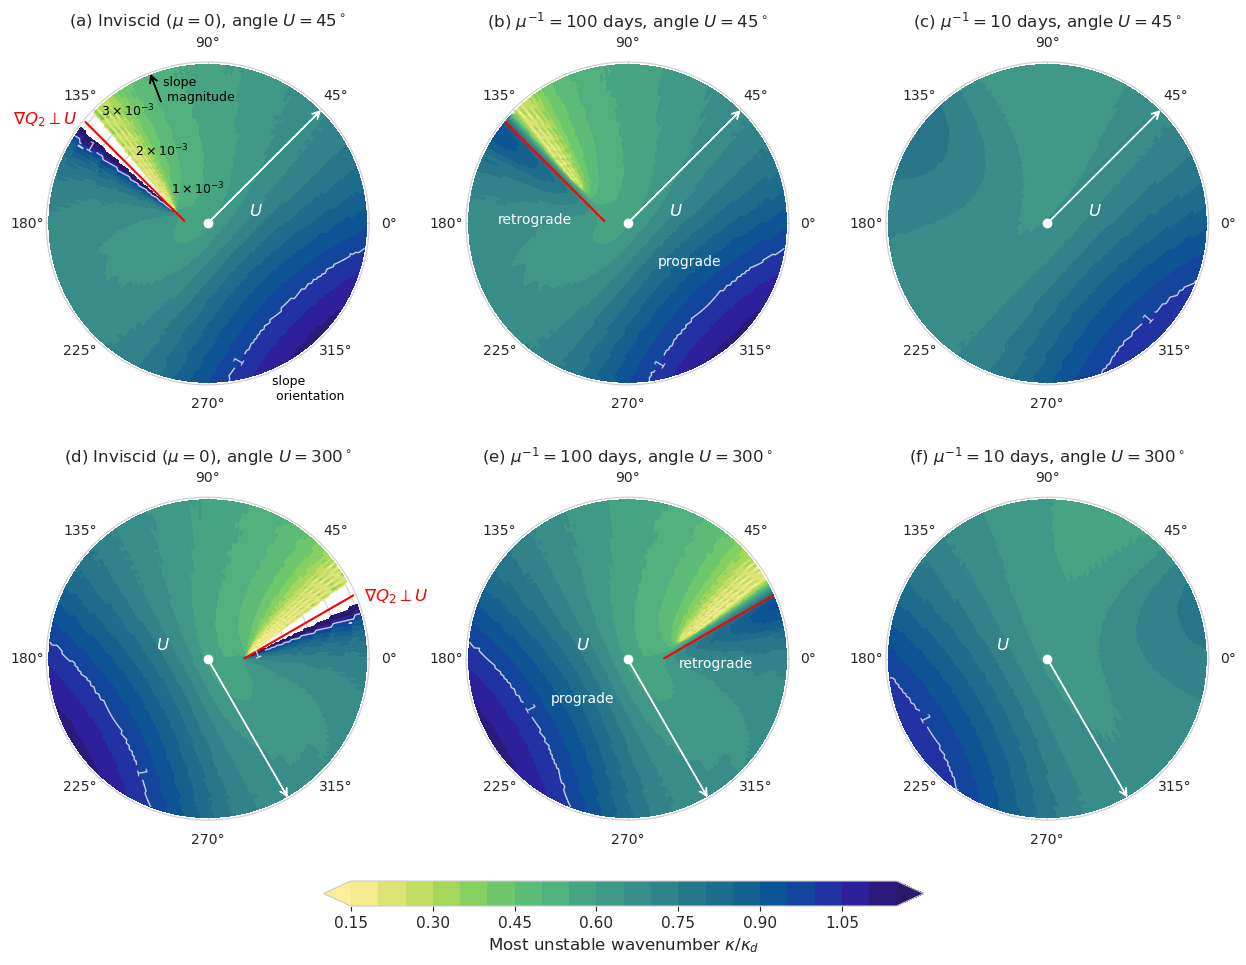

In [8]:
def plotNonzonalK(fig,ax,data,shear_angle,phi_range,levels=25):
    plot = ax.contourf(phi_range,alpha_range,data,cmap='cmo.haline_r',levels=levels,extend='both')
    kdlevel = ax.contour(phi_range,alpha_range,data,levels=[1],colors='white',linewidths=1,alpha=0.75)
    ax.clabel(kdlevel, inline=True, fontsize=10)
    ax.set_yticklabels([])
    ax.arrow(np.deg2rad(shear_angle),0,0,3e-3,facecolor='white',length_includes_head=True,head_length=1e-4,head_width=np.pi/60,overhang=1.5)
    ax.set_ylim(0,3.1e-3)
    ax.scatter(0,0,color='white')
    return plot


fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(15,10),subplot_kw={'projection': 'polar'})

levels = np.arange(0.15,1.151,0.05)
plot1=plotNonzonalK(fig,ax1,U_45deg_nofric_fine_k,45,phi_range_fine,levels=levels)
plotNonzonalK(fig,ax2,U_45deg_mu_weak_fine_k,45,phi_range_fine,levels=levels)
plotNonzonalK(fig,ax3,U_45deg_mu_intm_fine_k,45,phi_range_fine,levels=levels)
plotNonzonalK(fig,ax4,U_300deg_nofric_fine_k,300,phi_range_fine,levels=levels)
plotNonzonalK(fig,ax5,U_300deg_mu_weak_fine_k,300,phi_range_fine,levels=levels)
plotNonzonalK(fig,ax6,U_300deg_mu_intm_fine_k,300,phi_range_fine,levels=levels)

cbar_ax = fig.add_axes([0.31, 0.03, 0.4, 0.025])
cbar = fig.colorbar(plot1, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=11)
cbar.set_label(r'Most unstable wavenumber $\kappa/\kappa_d$',fontsize=12)

ax1.set_title(r'(a) Inviscid ($\mu = 0$), angle $U = 45^\circ$')
ax2.set_title(r'(b) $\mu^{-1} = 100$ days, angle $U = 45^\circ$')
ax3.set_title(r'(c) $\mu^{-1} = 10$ days, angle $U = 45^\circ$')
ax4.set_title(r'(d) Inviscid ($\mu = 0$), angle $U = 300^\circ$')
ax5.set_title(r'(e) $\mu^{-1} = 100$ days, angle $U = 300^\circ$')
ax6.set_title(r'(f) $\mu^{-1} = 10$ days, angle $U = 300^\circ$')

for ax in [ax1,ax2,ax3]:
    ax.text(np.deg2rad(10),0.8e-3,'$U$',fontsize=12,color='white')
for ax in [ax4,ax5,ax6]:
    ax.text(np.deg2rad(170),1e-3,'$U$',fontsize=12,color='white')

for ax in [ax1,ax2]:
    ax.plot(angle_range_45,alpha_range,color='r')
for ax in [ax4,ax5]:
    ax.plot(angle_range_300,alpha_range,color='r')
ax1.text(np.deg2rad(153),4.2e-3,r'$\nabla Q_2 \perp U$',fontsize=12,color='r')
ax4.text(np.deg2rad(20),3.2e-3,r'$\nabla Q_2 \perp U$',fontsize=12,color='r')

ax1.text(np.deg2rad(135),2.9e-3,r'$3 \times 10^{-3}$',fontsize=9,color='k')#,alpha=0.5)
ax1.text(np.deg2rad(137),1.9e-3,r'$2 \times 10^{-3}$',fontsize=9,color='k')#,alpha=0.5)
ax1.text(np.deg2rad(142),0.9e-3,r'$1 \times 10^{-3}$',fontsize=9,color='k')#,alpha=0.5)
ax1.text(np.deg2rad(110),2.5e-3,'slope \n magnitude',fontsize=9,color='k')#,alpha=0.5)
ax1.arrow(np.deg2rad(111),2.5e-3,0,0.5e-3,edgecolor='k',length_includes_head=True,head_length=1e-4,head_width=np.pi/60,overhang=1.5)
ax1.text(np.deg2rad(290),3.6e-3,'slope \n orientation',fontsize=9,color='k')

ax2.text(np.deg2rad(305),1e-3,r'prograde',fontsize=10,color='white')
ax2.text(np.deg2rad(180),2.5e-3,r'retrograde',fontsize=10,color='white')

ax5.text(np.deg2rad(350),1e-3,r'retrograde',fontsize=10,color='white')
ax5.text(np.deg2rad(210),1.7e-3,r'prograde',fontsize=10,color='white')

plt.subplots_adjust(hspace=0.3,wspace=0.3)
plt.show()

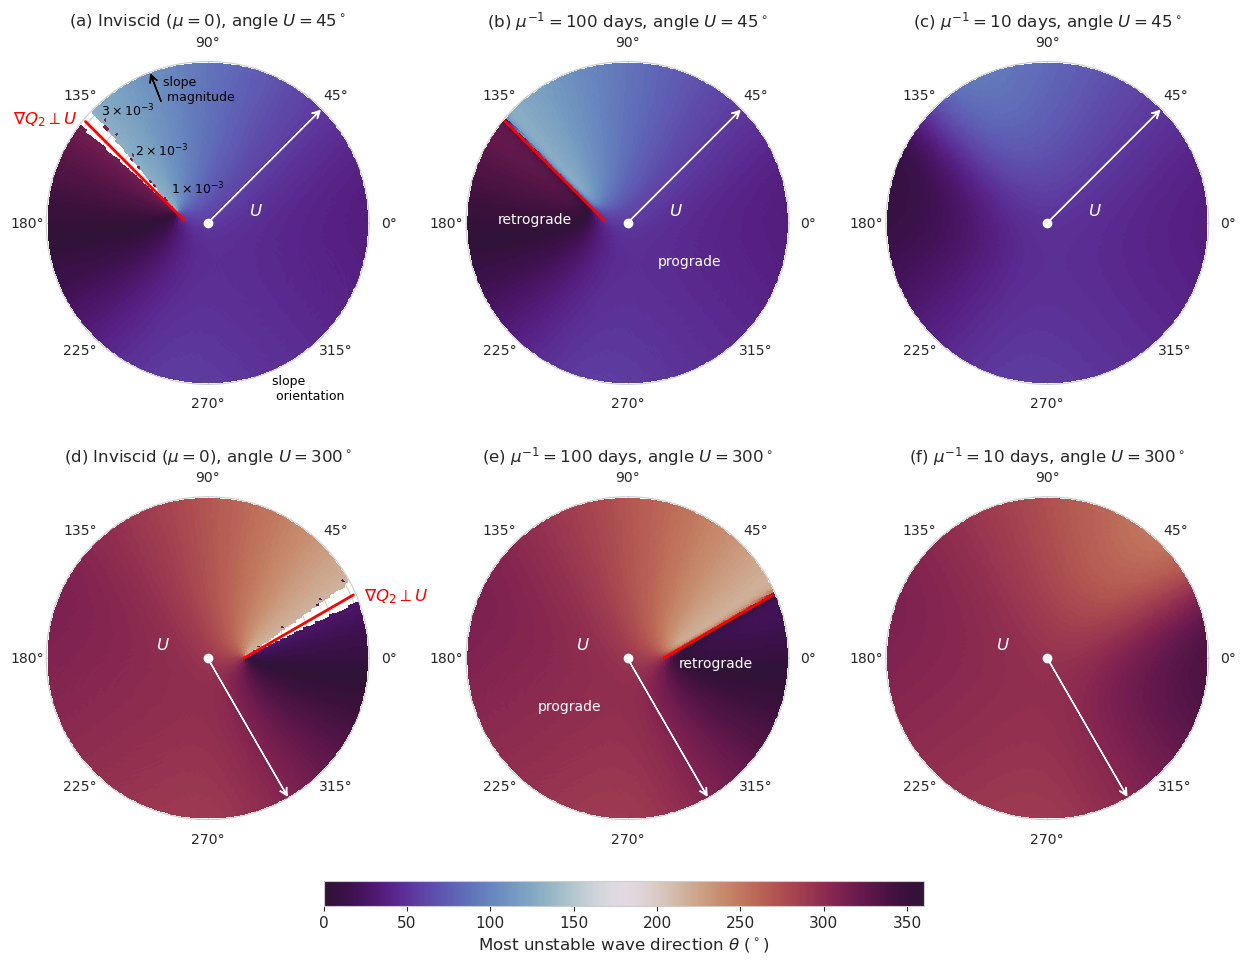

In [9]:
def plotNonzonalTheta(fig,ax,data,shear_angle,phi_range):
    plot = ax.pcolormesh(phi_range,alpha_range,data,cmap='twilight_shifted',vmin=0,vmax=360)
    ax.set_yticklabels([])
    ax.arrow(np.deg2rad(shear_angle),0,0,3e-3,facecolor='white',length_includes_head=True,head_length=1e-4,head_width=np.pi/60,overhang=1.5)
    ax.set_ylim(0,3.1e-3)
    ax.scatter(0,0,color='white')
    return plot


fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(15,10),subplot_kw={'projection': 'polar'})

plot1=plotNonzonalTheta(fig,ax1,U_45deg_nofric_fine_theta_cr,45,phi_range_fine)
plotNonzonalTheta(fig,ax2,U_45deg_mu_weak_fine_theta_cr,45,phi_range_fine)
plotNonzonalTheta(fig,ax3,U_45deg_mu_intm_fine_theta_cr,45,phi_range_fine)
plotNonzonalTheta(fig,ax4,U_300deg_nofric_fine_theta_cr,300,phi_range_fine)
plotNonzonalTheta(fig,ax5,U_300deg_mu_weak_fine_theta_cr,300,phi_range_fine)
plotNonzonalTheta(fig,ax6,U_300deg_mu_intm_fine_theta_cr,300,phi_range_fine)

cbar_ax = fig.add_axes([0.31, 0.03, 0.4, 0.025])
cbar = fig.colorbar(plot1, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=11)
cbar.set_label(r'Most unstable wave direction $\theta$ ($^\circ$)',fontsize=12)

ax1.set_title(r'(a) Inviscid ($\mu = 0$), angle $U = 45^\circ$')
ax2.set_title(r'(b) $\mu^{-1} = 100$ days, angle $U = 45^\circ$')
ax3.set_title(r'(c) $\mu^{-1} = 10$ days, angle $U = 45^\circ$')
ax4.set_title(r'(d) Inviscid ($\mu = 0$), angle $U = 300^\circ$')
ax5.set_title(r'(e) $\mu^{-1} = 100$ days, angle $U = 300^\circ$')
ax6.set_title(r'(f) $\mu^{-1} = 10$ days, angle $U = 300^\circ$')

for ax in [ax1,ax2,ax3]:
    ax.text(np.deg2rad(10),0.8e-3,'$U$',fontsize=12,color='white')
for ax in [ax4,ax5,ax6]:
    ax.text(np.deg2rad(170),1e-3,'$U$',fontsize=12,color='white')

for ax in [ax1,ax2]:
    ax.plot(angle_range_45,alpha_range,color='r',lw=2)
for ax in [ax4,ax5]:
    ax.plot(angle_range_300,alpha_range,color='r',lw=2)
ax1.text(np.deg2rad(153),4.2e-3,r'$\nabla Q_2 \perp U$',fontsize=12,color='r')
ax4.text(np.deg2rad(20),3.2e-3,r'$\nabla Q_2 \perp U$',fontsize=12,color='r')

ax1.text(np.deg2rad(135),2.9e-3,r'$3 \times 10^{-3}$',fontsize=9,color='k')#,alpha=0.5)
ax1.text(np.deg2rad(137),1.9e-3,r'$2 \times 10^{-3}$',fontsize=9,color='k')#,alpha=0.5)
ax1.text(np.deg2rad(142),0.9e-3,r'$1 \times 10^{-3}$',fontsize=9,color='k')#,alpha=0.5)
ax1.text(np.deg2rad(110),2.5e-3,'slope \n magnitude',fontsize=9,color='k')#,alpha=0.5)
ax1.arrow(np.deg2rad(111),2.5e-3,0,0.5e-3,edgecolor='k',length_includes_head=True,head_length=1e-4,head_width=np.pi/60,overhang=1.5)
ax1.text(np.deg2rad(290),3.6e-3,'slope \n orientation',fontsize=9,color='k')

ax2.text(np.deg2rad(305),1e-3,r'prograde',fontsize=10,color='white')
ax2.text(np.deg2rad(180),2.5e-3,r'retrograde',fontsize=10,color='white')

ax5.text(np.deg2rad(350),1e-3,r'retrograde',fontsize=10,color='white')
ax5.text(np.deg2rad(210),2e-3,r'prograde',fontsize=10,color='white')

plt.subplots_adjust(hspace=0.3,wspace=0.3)
plt.show()

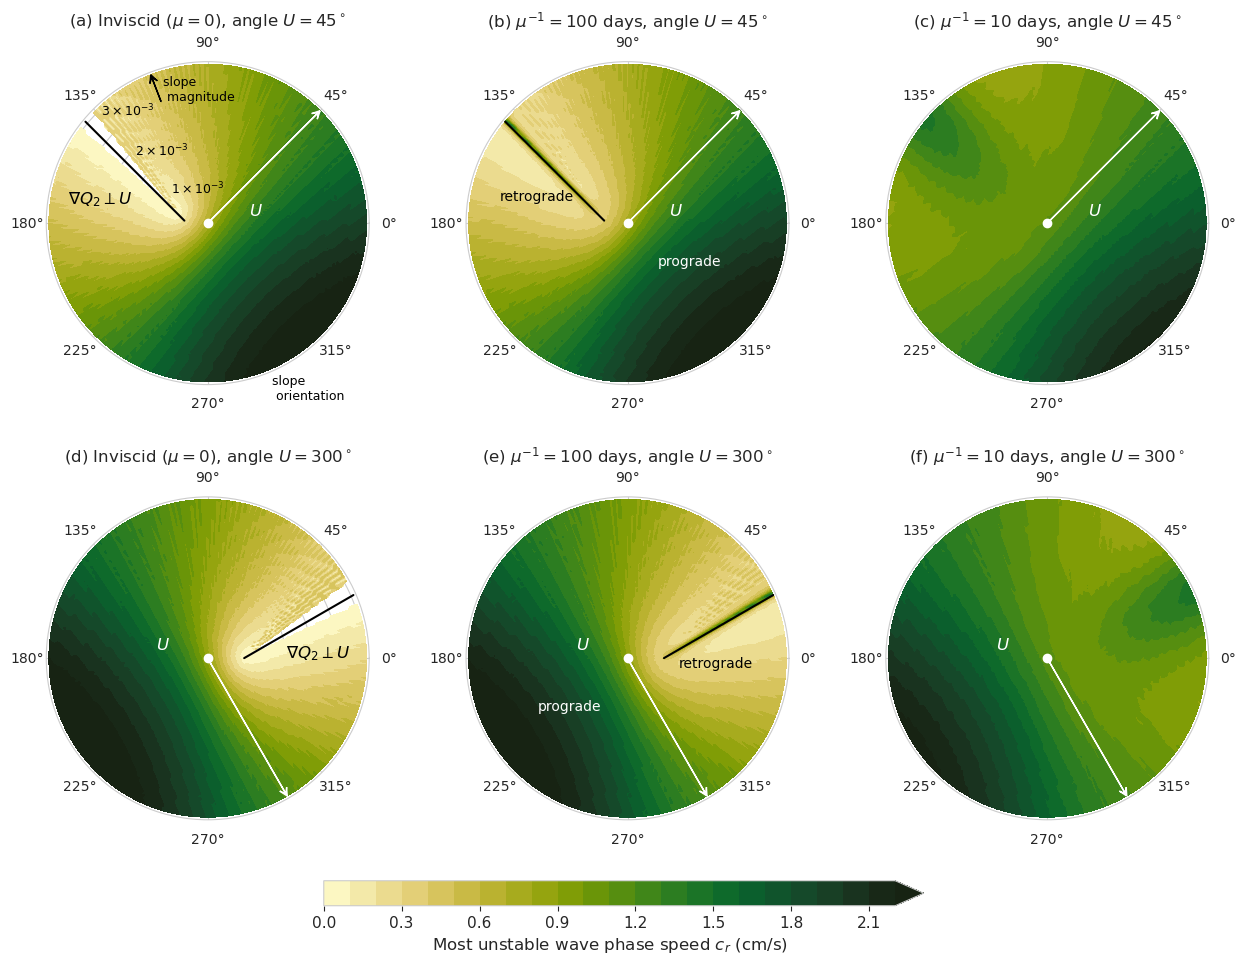

In [10]:
def plotNonzonalC(fig,ax,data,shear_angle,phi_range):
    plot = ax.contourf(phi_range,alpha_range,abs(data),cmap='cmo.speed',levels=np.arange(0,2.21,0.1),extend='max')
    ax.set_yticklabels([])
    ax.arrow(np.deg2rad(shear_angle),0,0,3e-3,facecolor='white',length_includes_head=True,head_length=1e-4,head_width=np.pi/60,overhang=1.5)
    ax.set_ylim(0,3.1e-3)
    ax.scatter(0,0,color='white')
    return plot


fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(15,10),subplot_kw={'projection': 'polar'})

plot1=plotNonzonalC(fig,ax1,U_45deg_nofric_fine_cr,45,phi_range_fine)
plotNonzonalC(fig,ax2,U_45deg_mu_weak_fine_cr,45,phi_range_fine)
plotNonzonalC(fig,ax3,U_45deg_mu_intm_fine_cr,45,phi_range_fine)
plotNonzonalC(fig,ax4,U_300deg_nofric_fine_cr,300,phi_range_fine)
plotNonzonalC(fig,ax5,U_300deg_mu_weak_fine_cr,300,phi_range_fine)
plotNonzonalC(fig,ax6,U_300deg_mu_intm_fine_cr,300,phi_range_fine)

cbar_ax = fig.add_axes([0.31, 0.03, 0.4, 0.025])
cbar = fig.colorbar(plot1, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=11)
cbar.set_label(r'Most unstable wave phase speed $c_r$ (cm/s)',fontsize=12)

ax1.set_title(r'(a) Inviscid ($\mu = 0$), angle $U = 45^\circ$')
ax2.set_title(r'(b) $\mu^{-1} = 100$ days, angle $U = 45^\circ$')
ax3.set_title(r'(c) $\mu^{-1} = 10$ days, angle $U = 45^\circ$')
ax4.set_title(r'(d) Inviscid ($\mu = 0$), angle $U = 300^\circ$')
ax5.set_title(r'(e) $\mu^{-1} = 100$ days, angle $U = 300^\circ$')
ax6.set_title(r'(f) $\mu^{-1} = 10$ days, angle $U = 300^\circ$')

for ax in [ax1,ax2,ax3]:
    ax.text(np.deg2rad(10),0.8e-3,'$U$',fontsize=12,color='white')
for ax in [ax4,ax5,ax6]:
    ax.text(np.deg2rad(170),1e-3,'$U$',fontsize=12,color='white')

for ax in [ax1,ax2]:
    ax.plot(angle_range_45,alpha_range,color='k')
for ax in [ax4,ax5]:
    ax.plot(angle_range_300,alpha_range,color='k')
ax1.text(np.deg2rad(172),2.7e-3,r'$\nabla Q_2 \perp U$',fontsize=12,color='k')
ax4.text(np.deg2rad(0),1.5e-3,r'$\nabla Q_2 \perp U$',fontsize=12,color='k')

ax1.text(np.deg2rad(135),2.9e-3,r'$3 \times 10^{-3}$',fontsize=9,color='k')#,alpha=0.5)
ax1.text(np.deg2rad(137),1.9e-3,r'$2 \times 10^{-3}$',fontsize=9,color='k')#,alpha=0.5)
ax1.text(np.deg2rad(142),0.9e-3,r'$1 \times 10^{-3}$',fontsize=9,color='k')#,alpha=0.5)
ax1.text(np.deg2rad(110),2.5e-3,'slope \n magnitude',fontsize=9,color='k')#,alpha=0.5)
ax1.arrow(np.deg2rad(111),2.5e-3,0,0.5e-3,edgecolor='k',length_includes_head=True,head_length=1e-4,head_width=np.pi/60,overhang=1.5)
ax1.text(np.deg2rad(290),3.6e-3,'slope \n orientation',fontsize=9,color='k')

ax2.text(np.deg2rad(305),1e-3,r'prograde',fontsize=10,color='white')
ax2.text(np.deg2rad(170),2.5e-3,r'retrograde',fontsize=10,color='k')

ax5.text(np.deg2rad(350),1e-3,r'retrograde',fontsize=10,color='k')
ax5.text(np.deg2rad(210),2e-3,r'prograde',fontsize=10,color='white')

plt.subplots_adjust(hspace=0.3,wspace=0.3)
plt.show()